In [2]:
#imports
import numpy as np
import pandas as pd # trifecta
import matplotlib.pyplot as plt

import h5py #to read in h5 file 
import random #to shuffle indices

from numpy import pi
from scipy.signal import medfilt
from sklearn import preprocessing

import sys
import os 

from rnn_utils import *

np.random.seed(0) #seed for reproducability

num_angles = 30
wings=2

In [2]:
lookback=100 #how many timepoints back am I looking // lookback
num_angles = 30
num_samples = int(1e5)
batch_size = 32
num_batches = int(num_samples/batch_size) 
ja_slice = num_batches*lookback
depth = 1 #how many time points into the future am I predicting
offset = int(4e4)
split_prop = 0.8
split_indx = int(split_prop*num_samples)

jaFolder = '/home/ishan/honors_thesis/nongithub/joint_angles/'

X, Y = create_dataset(jaFolder);
#create_dataset is in rnn_utils.py now, this 
#Check that it works
print(np.all(X[:,1:] == Y[:, :99]))

True


In [3]:
Xnorm, Xscaler = normalize_set(X)
Ynorm, Yscaler = normalize_set(Y)
Xtrain, Xval = Xnorm[:split_indx], Xnorm[split_indx:]
Ytrain, Yval = Ynorm[:split_indx], Ynorm[split_indx:]

In [4]:
Xtrain2 = h5py.File('/home/ishan/honors_thesis/nongithub/training_set/Xtrain.h5')['joint_angles']
Ytrain2 = h5py.File('/home/ishan/honors_thesis/nongithub/training_set/Ytrain.h5')['joint_angles']
Xval2   = h5py.File('/home/ishan/honors_thesis/nongithub/training_set/Xval.h5')['joint_angles']
Yval2   = h5py.File('/home/ishan/honors_thesis/nongithub/training_set/Yval.h5')['joint_angles']

In [9]:
print(np.all(Xtrain == Xtrain2), np.all(Ytrain == Ytrain2), np.all(Xval == Xval2), np.all(Yval == Yval2))

from sklearn.externals.joblib import dump, load
dump(Xscaler, 'Xscaler_val.bin', compress=True)
dump(Yscaler, 'Yscaler_val.bin', compress=True)

Xscaler2 = load('Xscaler_val.bin')
Yscaler2 = load('Yscaler_val.bin')
print(np.all(Xscaler.mean_ == Xscaler2.mean_), np.all(Yscaler.mean_ == Yscaler2.mean_), 
      np.all(Xscaler.scale_ == Xscaler2.scale_), np.all(Yscaler.scale_ == Yscaler2.scale_))

False False False False
True True True True


In [6]:
writeData(Xtrain, Ytrain, Xval, Yval,
          outFolder='/home/ishan/honors_thesis/validation_set')

'done!'

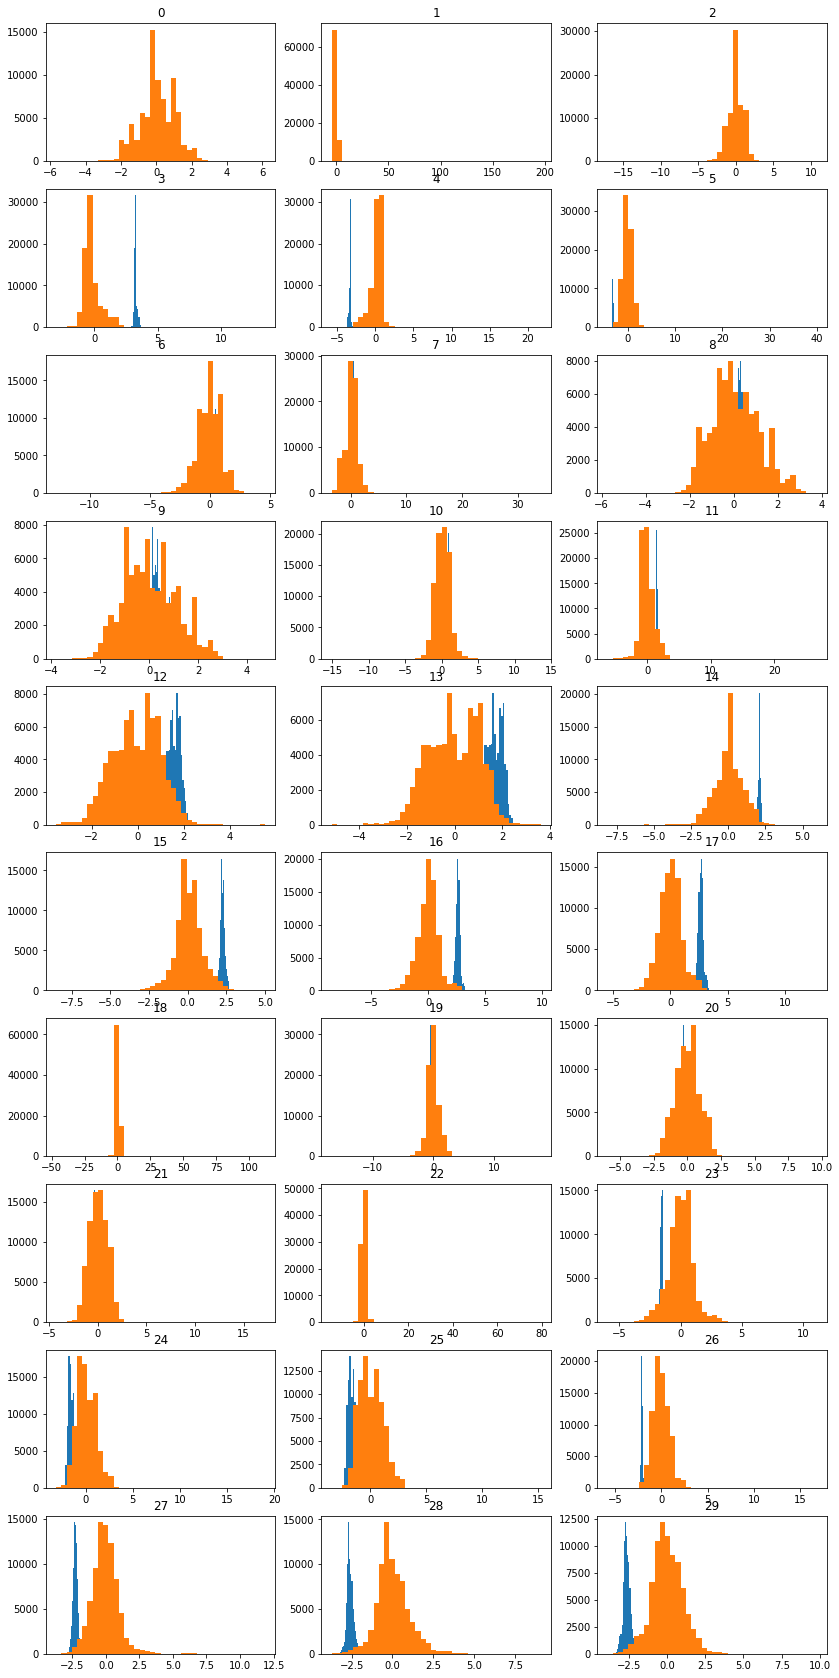

In [134]:
fig, axes = plt.subplots(10,3,figsize=(14,30))

for ang in range(num_angles):
    ax = axes[ang//3][ang%3]
    ax.set_title(str(ang))
    ax.hist(Xflat[:80000,ang], bins=40)
    ax.hist(Xnormf[:80000,ang], bins=40)

# Checks

In [3]:
jaFolder = '/home/ishan/honors_thesis/joint_angles'
posFolder = '/home/ishan/princeton_data/preds'
jaFile = os.listdir(jaFolder)[0]
h5File = jaFile[3:] #corresponding position time series
ja = h5py.File(os.path.join(jaFolder,jaFile))['joint_angles']
pos = h5py.File(os.path.join(posFolder,h5File))['positions_pred']

In [24]:
frame=1000
x_dist = pos[frame,0,:] - pos[frame,0,4]
y_dist = pos[frame,1,:] - pos[frame,1,4]

lngth = np.sqrt(x_dist**2+y_dist**2)

In [28]:
lngth.shape, ja[0].shape

((32,), (30,))

In [ ]:
#Y is 1 shifted forward
print(np.all(X[:,1:] == Y[:, :99]))

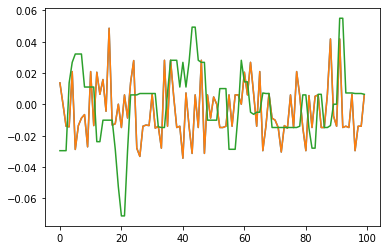

In [120]:
#plotting every 32 is an angle time series
plt.plot(X[:3200:32,3,0])
plt.plot(Y[:3200:32,2,0])
#and plotting lookback is a single angle time series, too
plt.plot(X[0,:,0])

In [169]:

dataFolder = '/home/ishan/princeton_data/preds/'
outFolder='/home/ishan/honors_thesis/joint_angles/'
#createJATimeSeries(dataFolder=dataFolder, outFolder=outFolder, median_filter = True)
#writeData(X_train, Y_train, X_test, Y_test, dtype='val_test', outFolder ='validation_set')

In [18]:
jaFolder = '/home/ishan/honors_thesis/joint_angles/'
X_train, Y_train, X_test, Y_test, indices_used = create_dataset(jaFolder=jaFolder, num_samples = 1500, split_proportion=0.667, lag=100, Y_shape = ('N', 'lag', 'num_feats'))
writeData(X_train, Y_train, X_test, Y_test, outFolder ='training_set')

'done!'

In [147]:
Xtrain = h5py.File('/home/ishan/honors_thesis/training_set/Xtrain.h5')['joint_angles']
Xtrain.shape

(30000, 100, 30)

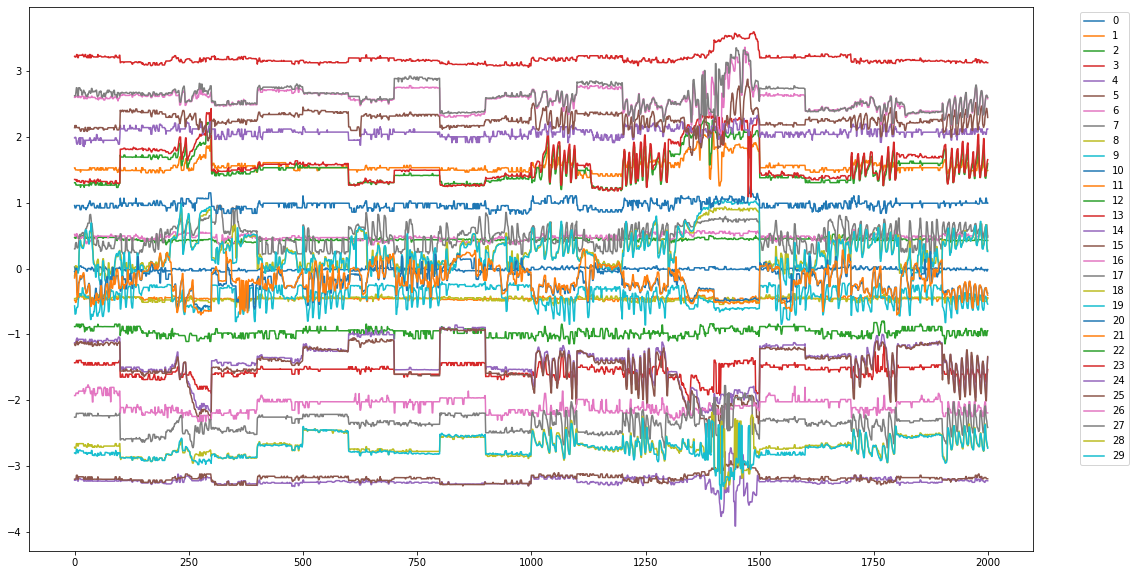

In [196]:
import matplotlib.colors as colors
plasma = plt.get_cmap('plasma')
fig, ax = plt.subplots(figsize=(18,10))
Xtrain = Xtrain[:].reshape((3000000,30))
ax.plot(Xtrain[:2000,]);
ax.legend(np.arange(30), bbox_to_anchor=(1.1,1.0))

In [8]:
#Some checks: 

#weird... investigate --> ja_091712_141601.h5

# 0 is the head --> angle should be pretty close to zero... 
# 1& 2 are eyes --> should be opposites of one another
# 3 & 4 are wings --> closer to π, opposites
# 5 is abdomen --> damn close to -π,

# fore legs (6-9, 18-21) are closer to 0 than to π, and larger than middle/back legs 
# mid legs (10-13, 22-25) are closer to π/2 (1.57), larger than frnt smaller than back
# hind legs(14-17, 26-29) are closer to the π end, larger than front + mid

#ja = h5py.File('/home/ishan/honors_thesis/joint_angles/ja_091712_141601.h5')['joint_angles']
#pos = h5py.File('/home/ishan/princeton_data/preds/091712_141601.h5')['positions_pred']
#ja = getJointAngles(pos[1000:])
for joint in range(num_angles):
    j = ja[:,joint]
    print('{0} - mean: {1:.4f}, stdev: {2:.4f}, max: {3:.4f}, min: {4:.4f}'.format(joint, j.mean(), j.std(), j.max(), j.min()))

0 - mean: 0.0012, stdev: 0.0185, max: 0.0846, min: -0.0955
1 - mean: -0.4337, stdev: 0.0306, max: 4.7124, min: -0.5957
2 - mean: 0.4382, stdev: 0.0212, max: 0.5875, min: -0.0053
3 - mean: 3.4285, stdev: 0.1391, max: 5.4925, min: 2.5205
4 - mean: -3.4976, stdev: 0.1751, max: 0.0000, min: -5.0503
5 - mean: -3.0650, stdev: 0.0625, max: 0.0000, min: -3.4375
6 - mean: 0.4995, stdev: 0.0343, max: 0.6947, min: 0.0000
7 - mean: 0.5490, stdev: 0.1030, max: 4.5150, min: 0.1223
8 - mean: 0.4911, stdev: 0.1957, max: 1.3615, min: -0.7907
9 - mean: 0.5472, stdev: 0.2462, max: 2.0164, min: -0.3948
10 - mean: 0.9943, stdev: 0.0768, max: 1.4877, min: 0.0000
11 - mean: 1.5671, stdev: 0.1431, max: 4.7124, min: 0.7101
12 - mean: 1.7276, stdev: 0.2107, max: 3.1416, min: 0.5860
13 - mean: 1.8465, stdev: 0.2522, max: 3.1399, min: 0.0000
14 - mean: 2.1290, stdev: 0.0978, max: 2.4694, min: 1.4935
15 - mean: 2.1895, stdev: 0.3295, max: 3.1416, min: 0.6645
16 - mean: 2.6675, stdev: 0.3732, max: 4.7019, min: 0.96

### Plots

In [10]:
def draw_line(point1, point2, frame=39, **kwargs):
    xs = [pos[frame, 0, point1], pos[frame, 0, point2]]
    ys = [pos[frame, 1, point1], pos[frame, 1, point2]]
    plt.plot(xs, ys, **kwargs)

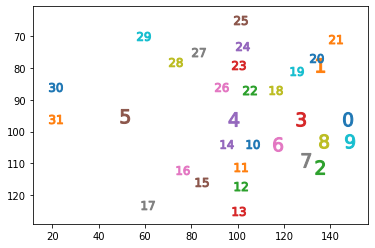

In [9]:
frame = 30
wings = 2
for ang in range(num_angles+wings):
    plt.scatter(pos[frame,0,ang], pos[frame,1,ang], marker='$'+str(ang)+'$', s=200)
plt.gca().invert_yaxis()

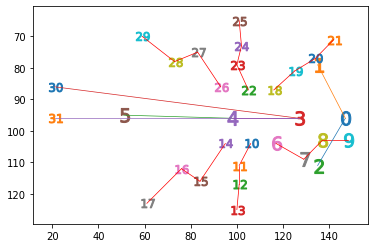

In [11]:
color = 'red'
linewidth=0.7
frame = 30
#frame = frame+1000
for p in range(6, 9, 1):
    draw_line(p, p+1, color=color, linewidth=linewidth, frame=frame)
for p in range(10, 13, 1):
    draw_line(p, p+1, color=color, linewidth=linewidth, frame=frame)
for p in range(14, 17, 1):
    draw_line(p, p+1, color=color, linewidth=linewidth, frame=frame)
for p in range(18, 21, 1):
    draw_line(p, p+1, color=color, linewidth=linewidth, frame=frame)
for p in range(22, 25, 1):
    draw_line(p, p+1, color=color, linewidth=linewidth, frame=frame)
for p in range(26, 29, 1):
    draw_line(p, p+1, color=color, linewidth=linewidth, frame=frame)
draw_line(2, 0, linewidth=linewidth, frame=frame)
draw_line(1, 0, linewidth=linewidth, frame=frame)
draw_line(5, 4, linewidth=linewidth, frame=frame)
draw_line(4, 3, color='purple', linewidth=linewidth, frame=frame)
draw_line(30, 3, linewidth=linewidth, frame=frame)
draw_line(31, 3, linewidth=linewidth, frame=frame)
for ang in range(num_angles+wings):
    plt.scatter(pos[frame,0,ang], pos[frame,1,ang], marker='$'+str(ang)+'$', s=200) #plots the 
plt.gca().invert_yaxis()

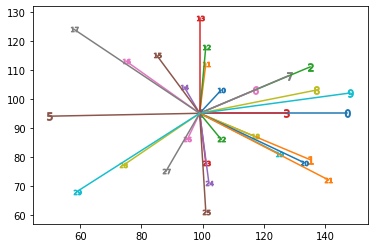

In [19]:
for i in range(num_angles):
    plt.scatter(pos[39,0,i], pos[39,1,i], marker='$'+str(i)+'$', s=60) #plots the 
plt.gca().invert_yaxis
for ang in range(num_angles):
    draw_line(4,ang)

In [89]:
def do_ac(func, plotting=False, *args, **kwargs):
    func(*args, **kwargs) #maybe explore this idea a little later

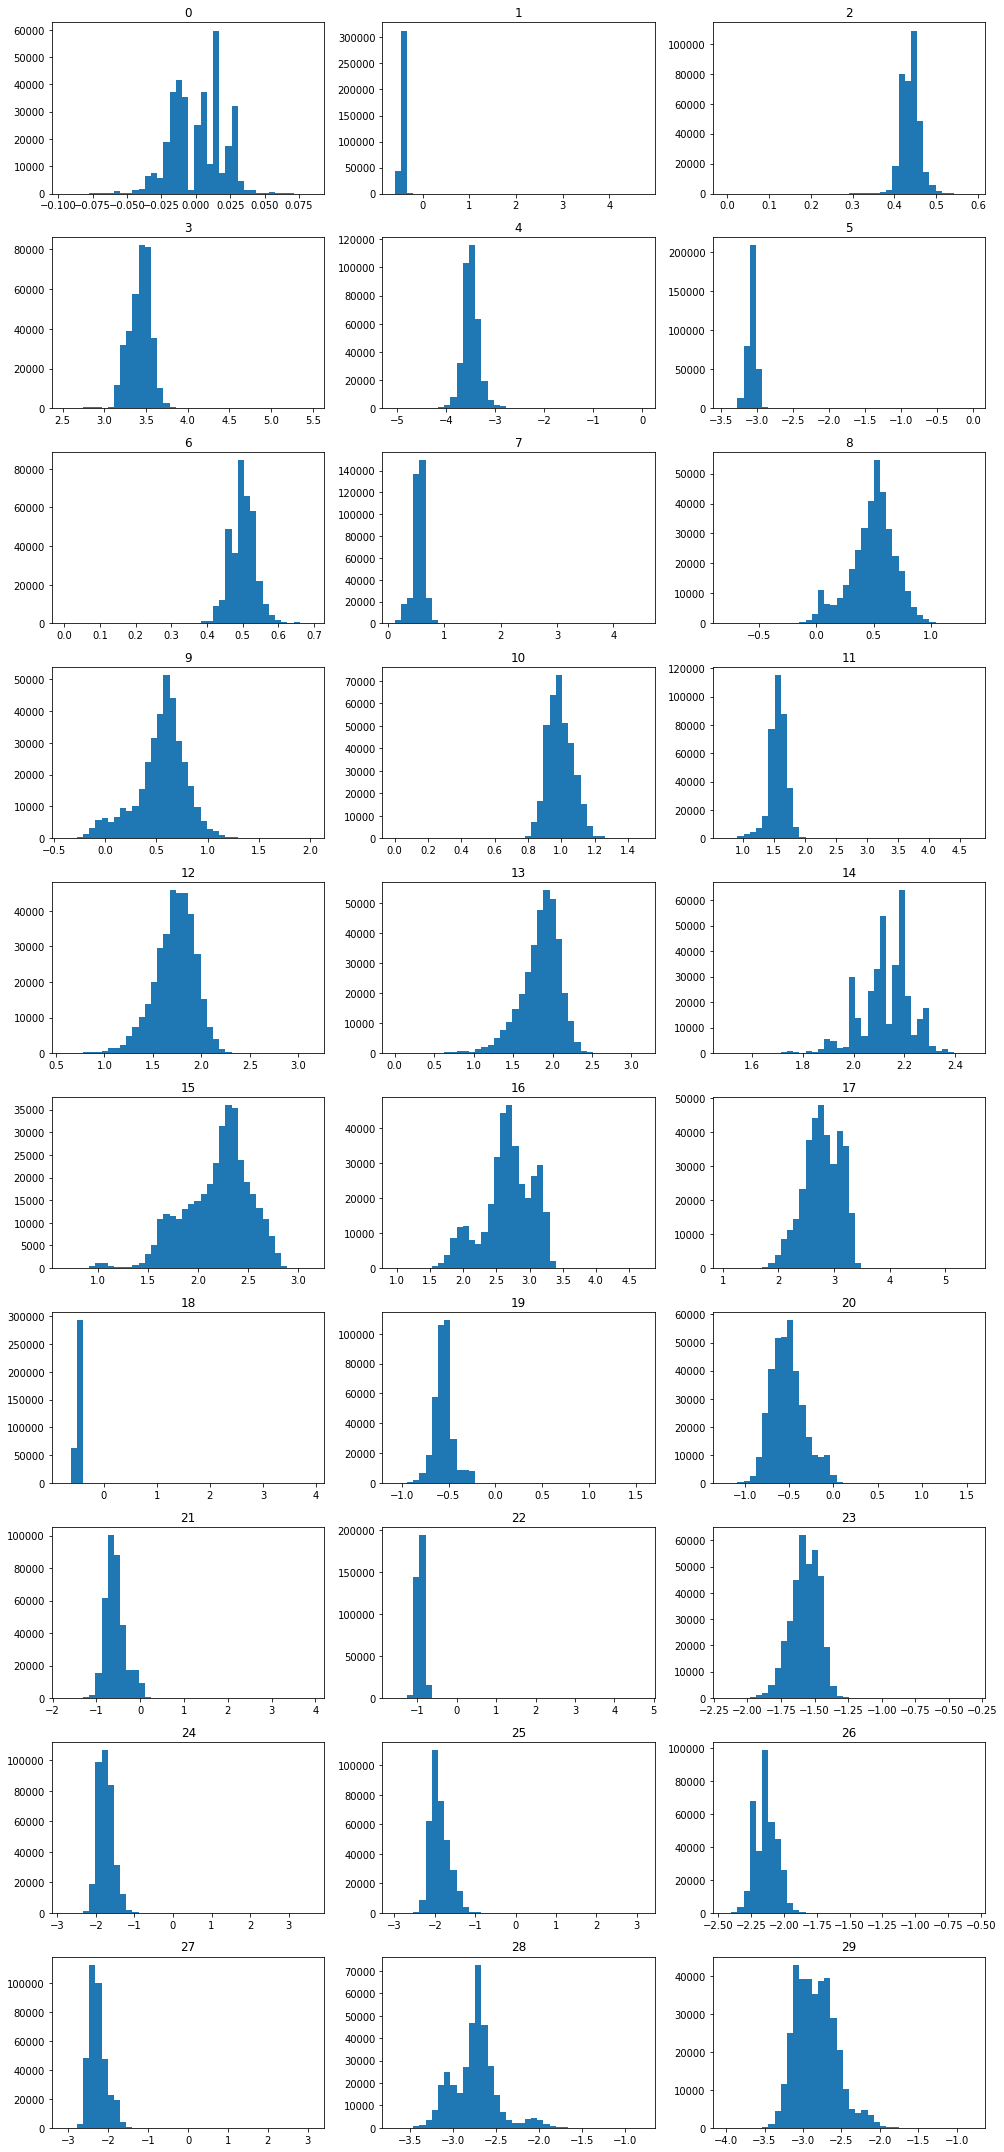

In [14]:
fig, axes = plt.subplots(10, 3, figsize=(14,30))

for ang in range(num_angles):
    ax = axes[ang//3][ang%3]
    ax.hist(ja[:,ang], bins=40);
    ax.set_title(str(ang))
plt.tight_layout()

In [21]:
#Checks - various checks, but it works... :) 
#X_train = h5py.File('validation_set/Xtrain.h5')['joint_angles']
#Y_train = h5py.File('validation_set/Ytrain.h5')['joint_angles']
#file = os.listdir(jaFolder)[0]
#ja = h5py.File(jaFolder + file)['joint_angles']

#Should be all trues 
np.all([X_train[j][i+1] == Y_train[j][i] for i in range(9) for j in range(10)])

True

### Joint angle plots

In [9]:
ja_mf = np.empty_like(ja)
for ang in range(num_angles):
    ja_mf[:,ang] = medfilt(ja[:,ang], kernel_size=3)

In [34]:
ja_mf = h5py.File('/home/ishan/honors_thesis/training_set/Xtrain.h5')['joint_angles']
ja = h5py.File('/home/ishan/honors_thesis/training_set[unfiltered]/Xtrain.h5')['joint_angles']

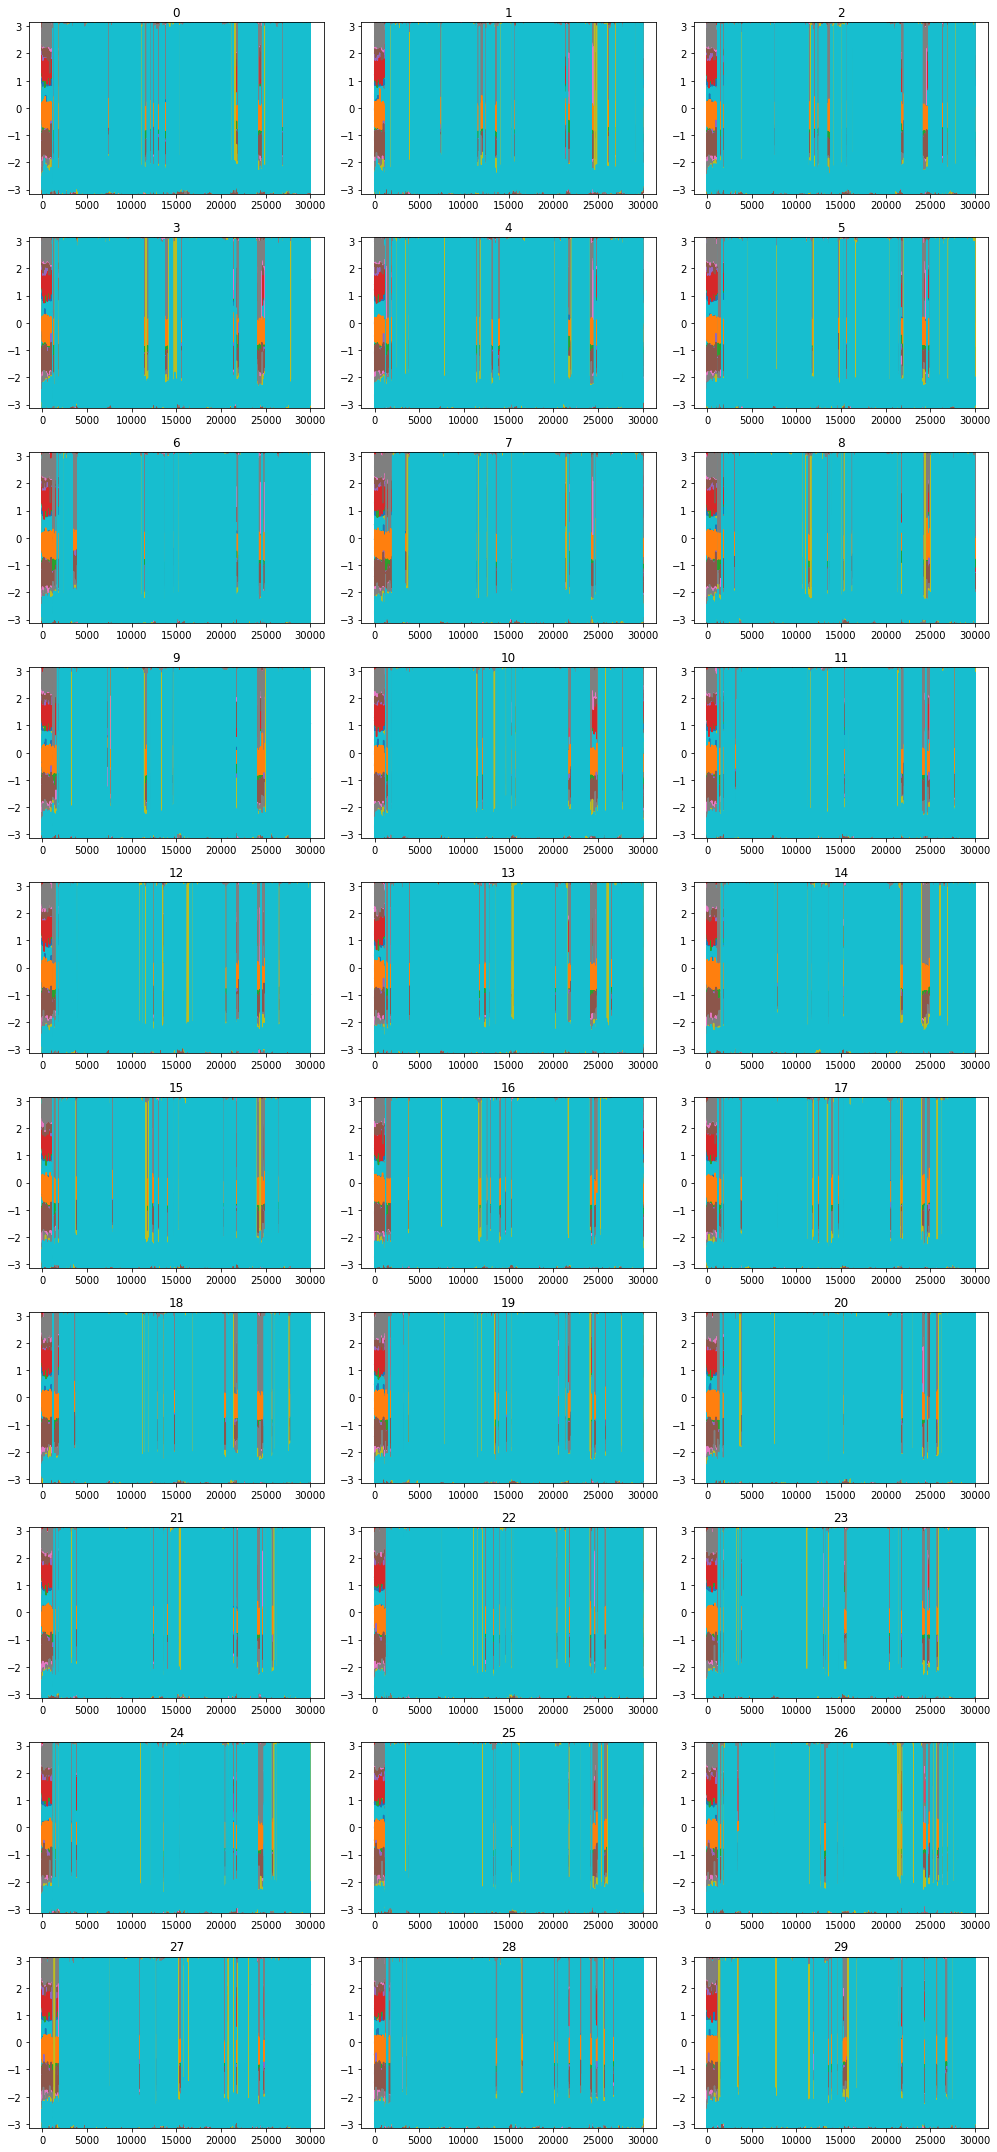

In [35]:
fig, axes = plt.subplots(10,3, figsize=(14,30))

for ang in range(num_angles):
    ax = axes[ang // 3][ang % 3]
    ax.plot(ja[:, ang])
    ax.plot(ja_mf[:1000, ang])
    ax.set_title(str(ang))
    ax.set_ylim(-np.pi,np.pi)
fig.tight_layout()
#fig.savefig('Angle Time Series[post_RLdistinction].png')

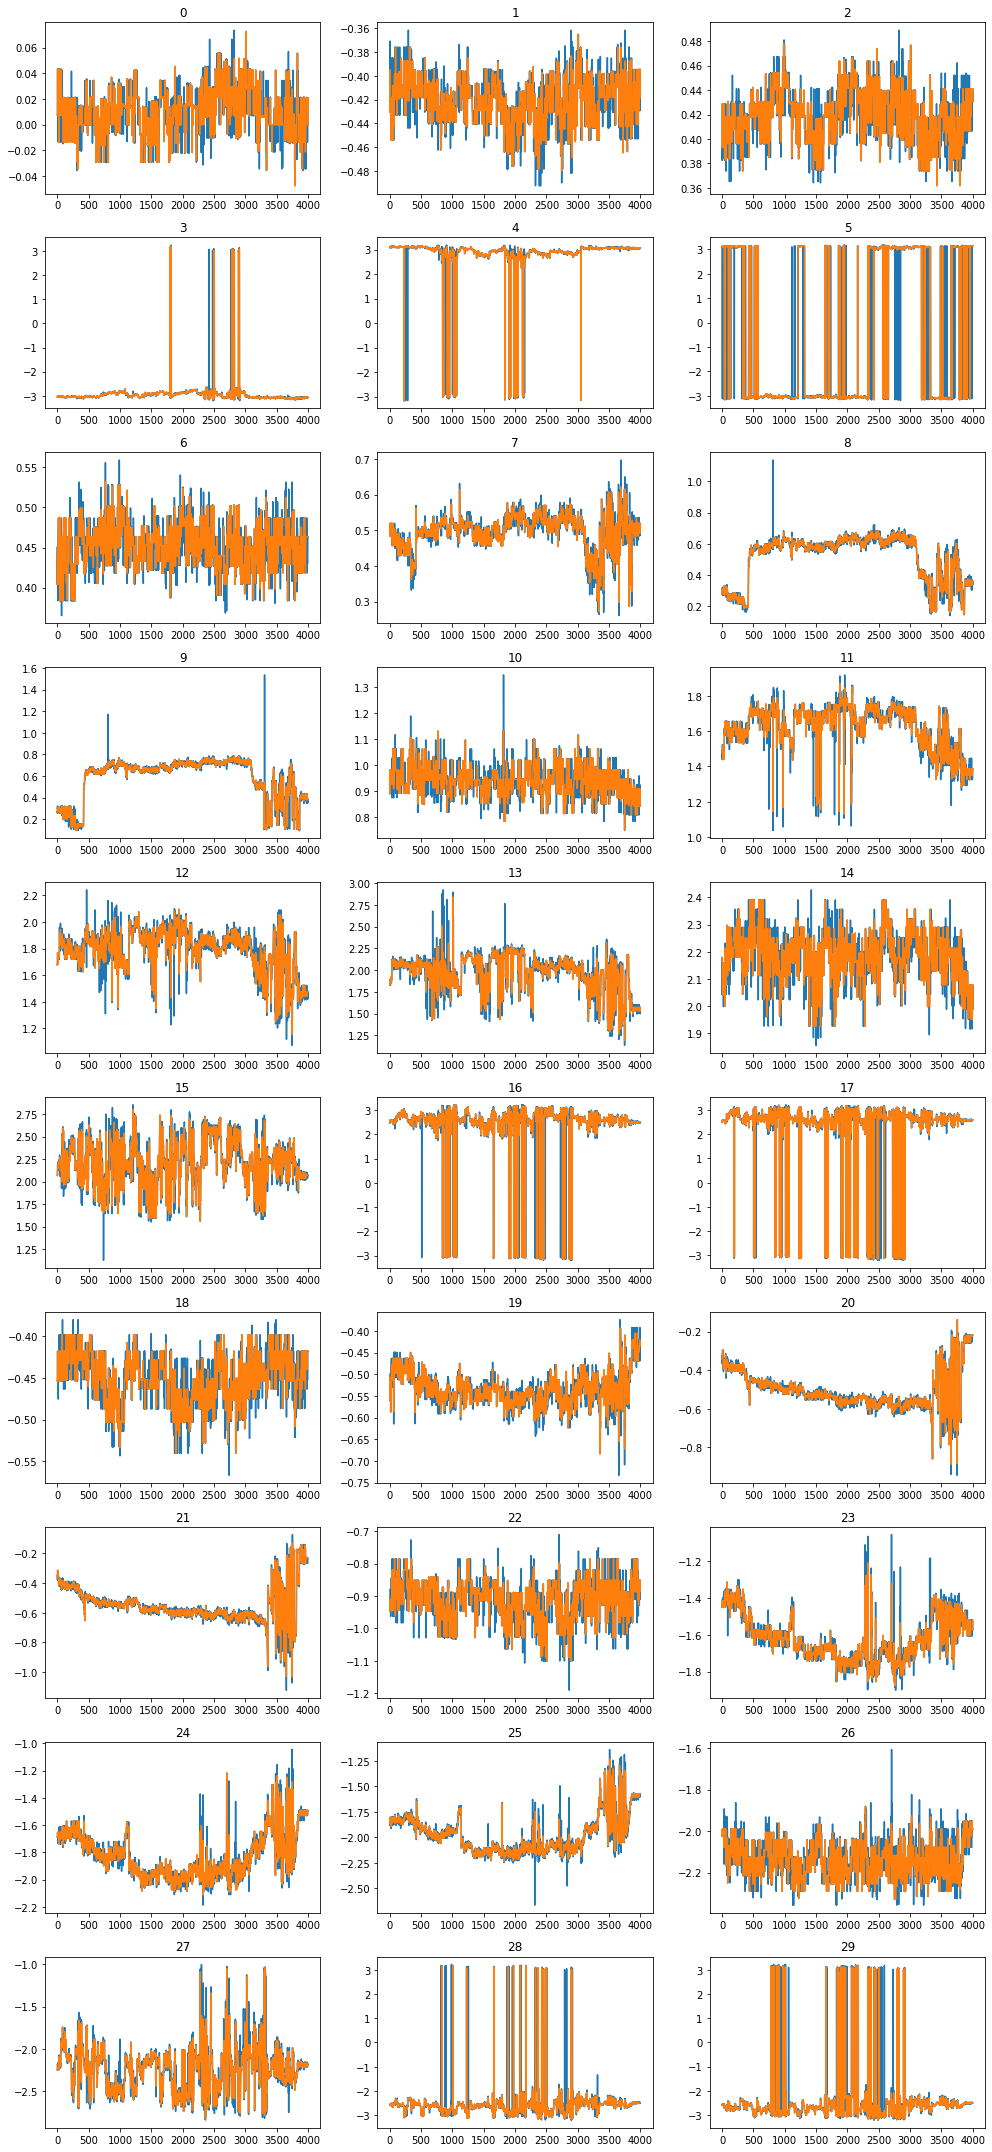

In [59]:
fig, axes = plt.subplots(10, 3, figsize=(14,30))

for ang in range(num_angles):
    #ja_mf = medfilt(ja[:,ang], kernel_size = 3)
    ax = axes[ang // 3][ang % 3]
    #ax.set_ylim(-3.14,3.14)
    ax.set_title(str(ang))
    _ = ax.plot(ja[1000:5000,ang], markersize = 7, label='raw time series')
    _ = ax.plot(ja_mf[1000:5000,ang], markersize=0.5, label='median filtered')
fig.tight_layout()

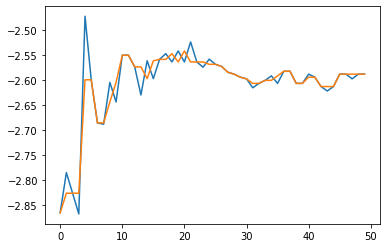

In [53]:
aoi=29
np.where(ja_mf[:,aoi] < -np.pi)[0]

ang1, ang2, ang2-ang1
x = pos[frame,:,3] - pos[frame,:,4]
a29=pos[frame,:,29]- pos[frame,:,4]
ang1 = np.arctan2(x[1], x[0])
ang2 = np.arctan2(a29[1], a29[0])

plt.plot(ja[frame-25:frame+25,29])
plt.plot(ja_mf[frame-25:frame+25,29])
plt.show()

In [ ]:
origin = pos[:,:,4]
neck = pos[:,:,3]
p=31
v1 = x = neck-origin
v2 = pos[:,:,p]-origin

ang1 = np.arctan2(v1[:,1], v1[:,0])
ang2 = np.arctan2(v2[:,1], v2[:,0])
plt.plot(ang1)
plt.plot(ang2)
plt.plot(ang2-ang1)

In [ ]:
ang2[ang2 > 0] = ang2[ang2 > 0] - 2*np.pi
plt.plot(ang1)
plt.plot(ang2)
plt.plot(ang2-ang1)